In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Calle\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
df = pd.read_csv('./data/imdb_sup.csv')
df = df.sample(frac=0.5, replace=False, random_state=1)
df.info()
df = df.drop('Sentiment', axis=1)
df.head()

In [4]:
df = df.drop_duplicates(keep="first",subset=["Review"])

In [5]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def clean_text(text):
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(text)

In [6]:
df['Clean_Review'] = df['Review'].apply(clean_text)
df.head()

,Review,Rating,Clean_Review
26247,"Claire Booth Luce's ""The Women"" shows relation...",7,Claire Booth Luce Women show relationship man ...
35067,_The Wild Life_ has an obvious resemblance to ...,7,Wild Life obvious resemblance Fast Times Ridge...
34590,This was the film that first indicated to me w...,8,film indicate great actor Martin Sheen modestl...
16668,The plot has already been described by other r...,4,plot describe reviewer simply add reason want ...
12196,Most of the comments have been positive but I ...,10,comment positive like add viewer focus set set...


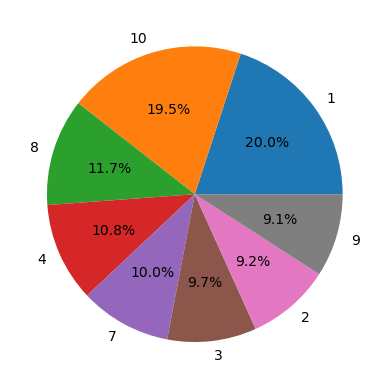

In [14]:
t = df['Rating'].value_counts()
labels = t.index
values = t.values

fig, ax = plt.subplots()
ax.pie(values,labels=labels,autopct='%1.1f%%')
fig.savefig('ratingpie.png')


In [19]:
sia = SentimentIntensityAnalyzer()
ps = df['Clean_Review'].apply(lambda x: sia.polarity_scores(x)).apply(pd.Series)
ps.drop(['compound'], axis=1, inplace=True)

ps = pd.concat([ps, df['Rating']], axis=1)

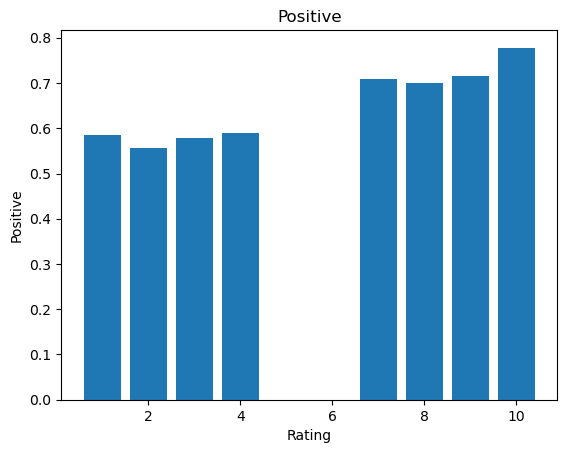

In [30]:
fig,ax = plt.subplots()
ax.bar(ps['Rating'],ps['pos'])
ax.set_title('Positive')
ax.set_xlabel('Rating')
ax.set_ylabel('Positive')
fig.savefig('sia_positive.png')



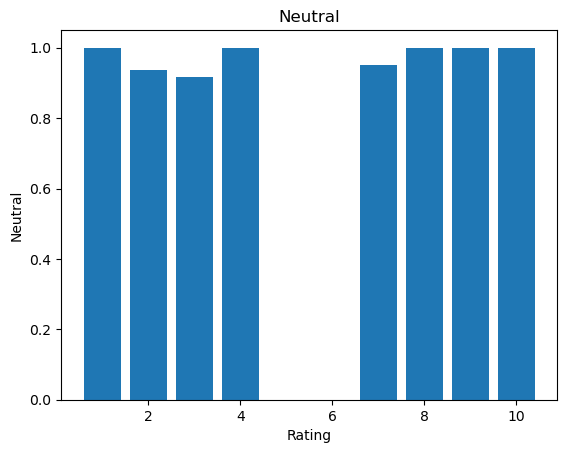

In [31]:
fig,ax = plt.subplots()
ax.bar(ps['Rating'],ps['neu'])
ax.set_title('Neutral')
ax.set_xlabel('Rating')
ax.set_ylabel('Neutral')
fig.savefig('sia_neutral.png')

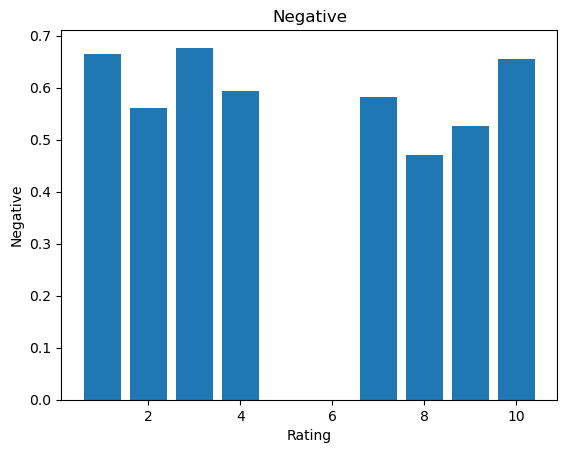

In [32]:
fig,ax = plt.subplots()
ax.bar(ps['Rating'],ps['neg'])
ax.set_title('Negative')
ax.set_xlabel('Rating')
ax.set_ylabel('Negative')
fig.savefig('sia_negative.png')

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['Clean_Review'].apply(lambda x: x.split(' ')))]
model = Doc2Vec(documents, vector_size=20, window=2, min_count=1, workers=4)
doc2vec_df = df['Clean_Review'].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ['doc2vec_vector_' + str(x) for x in doc2vec_df.columns]
doc2vec_df.head()

In [ ]:
df['posneg'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)
df.head()

In [36]:
X_vec = doc2vec_df
Y = df['posneg']

In [37]:
x_train_vec, x_test_vec, y_train_vec, y_test_vec = train_test_split(X_vec, 
                                                    Y, test_size=0.25, 
                                                    random_state=42)

In [42]:
model = RandomForestClassifier(random_state=42)
model.fit(x_train_vec, y_train_vec)

RandomForestClassifier(random_state=42)

In [43]:
rfc_report = classification_report(y_test_vec, model.predict(x_test_vec))
print(rfc_report)


              precision    recall  f1-score   support

           0       0.80      0.80      0.80      3126
           1       0.80      0.80      0.80      3100

    accuracy                           0.80      6226
   macro avg       0.80      0.80      0.80      6226
weighted avg       0.80      0.80      0.80      6226



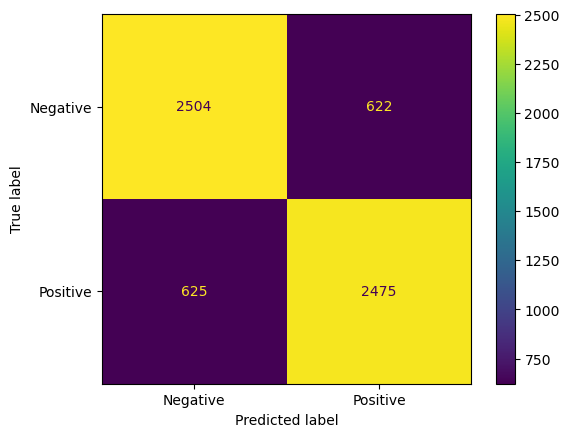

In [45]:
disp = ConfusionMatrixDisplay.from_estimator(model, x_test_vec, y_test_vec, display_labels=['Negative', 'Positive'])
disp.figure_.savefig('rfc_confusion_matrix.png')

In [46]:
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train_vec, y_train_vec)

LogisticRegression(random_state=42)

In [47]:
logreg_report = classification_report(y_test_vec, logreg.predict(x_test_vec))
print(logreg_report)

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3126
           1       0.81      0.80      0.80      3100

    accuracy                           0.81      6226
   macro avg       0.81      0.81      0.81      6226
weighted avg       0.81      0.81      0.81      6226



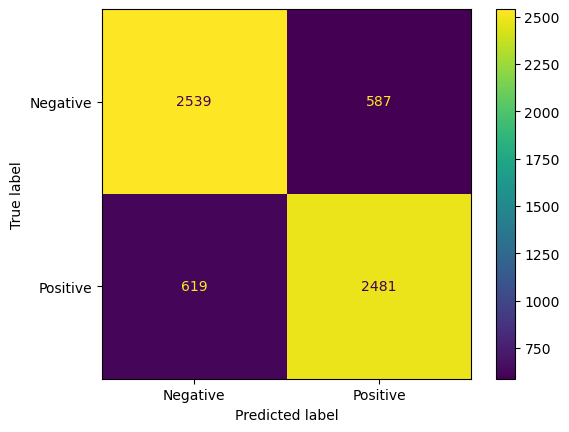

In [49]:
disp = ConfusionMatrixDisplay.from_estimator(logreg, x_test_vec, y_test_vec, display_labels=['Negative', 'Positive'])
disp.figure_.savefig('logreg_confusion_matrix.png')

In [50]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=42)
svc.fit(x_train_vec, y_train_vec)

c:\Users\Calle\anaconda3\envs\tdde16-project-py-3.9\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Calle\anaconda3\envs\tdde16-project-py-3.9\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

In [51]:
svc_report = classification_report(y_test_vec, svc.predict(x_test_vec))
print(svc_report)

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3126
           1       0.81      0.80      0.80      3100

    accuracy                           0.81      6226
   macro avg       0.81      0.81      0.81      6226
weighted avg       0.81      0.81      0.81      6226



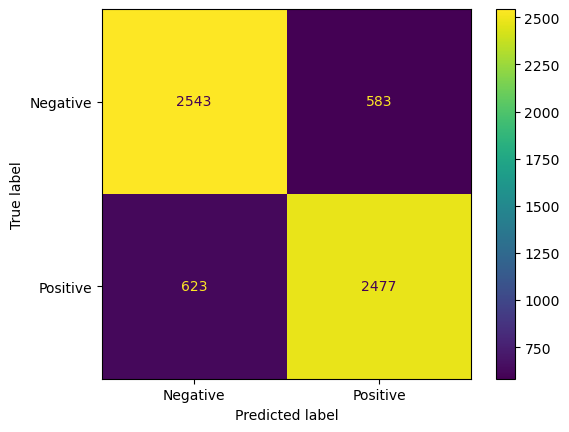

In [53]:
disp = ConfusionMatrixDisplay.from_estimator(svc, x_test_vec, y_test_vec, display_labels=['Negative', 'Positive'])
disp.figure_.savefig('svc_confusion_matrix.png')

In [55]:
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
def wordCloud_generator(data, color, color_map):
    #wave_mask = np.array(Image.open('cloud.png'))
    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                          #mask = wave_mask
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

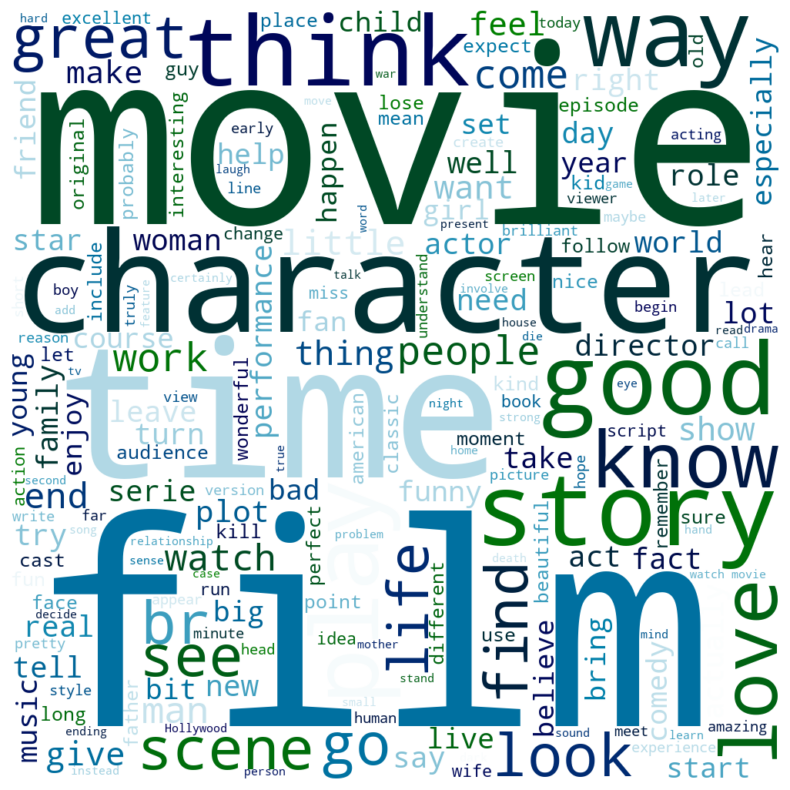

In [57]:
train_pos = df[df['posneg']== 1]
train_pos = train_pos['Clean_Review']
wordCloud_generator(train_pos, 'white', 'ocean')

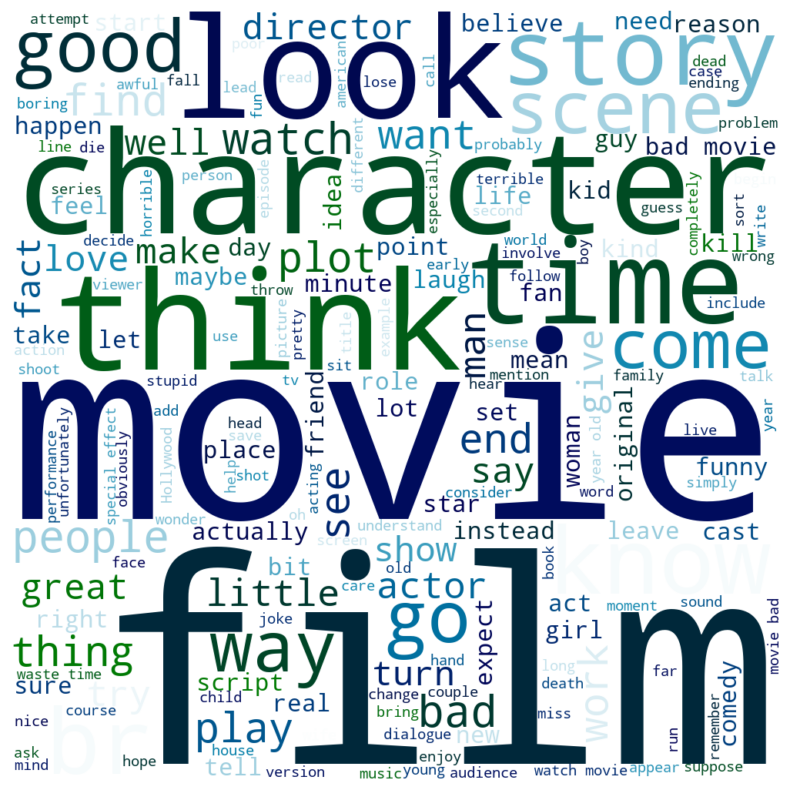

In [59]:
train_neg = df[df['posneg']== 0]
train_neg = train_neg['Clean_Review']
wordCloud_generator(train_neg, 'white', 'ocean')